# Defining Nominal Approaches in fmdtools

Nominal simulation approaches are used to evaluate the performance of a model over a set of input parameters. It can then be used to:
- define/understand the operational envelope for different system parameters (i.e., what inputs can the system safely encounter)
- quantify failure probabilities given stochastic inputs (i.e., if the statistical distribution of inputs are known, what is the resulting probability of hazards given the design)

In [1]:
from fmdtools.define.model import Model
from fmdtools.define.block import FxnBlock

import fmdtools.analyze as an
import fmdtools.sim.propagate as prop

The rover model (rover_model.py) from the examples module will be used to demonstrate this approach. The main task of the rover is to follow a given line from a starting location to an ending location. It model is made of following functions and flows.

Functions:
    - Power
    - Operator
    - Communications
    - Perception
    - Avionics
    - Override
    - Drive
    - Environment

Flows:
    - Groud
    - Pos_Signal
    - EE_12
    - EE_15
    - EE_5
    - Video
    - Avionics_Control
    - Motor_control
    - Switch
    - Comms
    - Ovverride_comms
    - Faultystates

It has helper functions that help visualize the rovers behavior overtime.

    - plot_map(mdl, mdlhist): helps visualize the ability of the rover to track a given line
    - plot_trajectories(
                            mdlhists,
                            nomhist=[],
                            app=[],
                            faultlabel="Faulty",
                            faultalpha=0.1,
                            range_hist={},
                            rangealpha=0.1,
                            setalpha=0.3,
                            show_labels=True,
                            title="Fault Trajectories",
                            textoffset=2.0,
                            mode_trunc=5,
                            mode_trunc_end=5,
                            xlim=None,
                            ylim=None,
                            figsize=(4, 4),
                            ax=False,
                            legend=True,
                        ): helps visualize the rover trajectories

    - plot_centerline_err(mdl, mdlhist): helps visualize how mucht the rover has deviated from the centerline.

Additionally, this model has a corresponding *parameter generation* class which generates the design parameters of the model given a reduced space of input parameters. The pssoible parameter inputs and their dafaults are listed below.

    linetype: str = "sine"              # line type (sine or turn)
    period: float = 1.0                 # period of the curve (for sine linetype)
    end: tuple = (10.0, 10.0)           # end of the curve (requires instantiation)
    initangle: float = 0.0              # initial rover angle
    linetype_set = ("sine", "turn")
    amp: float = 1.0                    # amplitude of sine wave   (input for sine linetype)
    wavelength: float = 50.0            # wavelength of sine wave (input for sine linetype)
    radius: float = 20.0                # radius of turn (input for turn linetype)
    start: float = 20.0                 # start of turn (input for turn linetype)
    ub_f: float = 10.0                  
    lb_f: float = -1.0
    ub_t: float = 10.0
    lb_t: float = -1.0
    ub_d: float = 2.0
    lb_d: float = -2.0
    cor_d: float = 1.0
    cor_t: float = 1.0
    cor_f: float = 1.0
    degradation: DegParam = DegParam()  # Degradation parameters
    drive_modes: dict = {"mode_args": "set"}   

In [2]:
from rover_model import Rover, plot_map, plot_centerline_err, RoverParam

Below shows the performance of the rover during a (default) turn with a radius of 20 meters that begins at 20 meters. As shown, there is a slight drift from the centerline, but not enough for the rover to get lost (that would take 1 meter of drift).

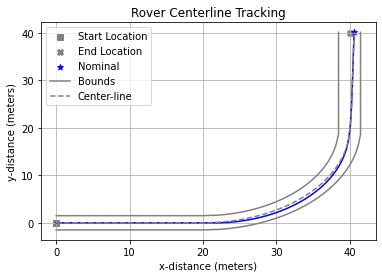

In [3]:
p = RoverParam(linetype="turn")
mdl = Rover(p=p)
results, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

Below shows the performance of the model over a sine wave. As shown, similar to the turn line type, the drift small enough to where the rover completes its mission within acceptable bounds.

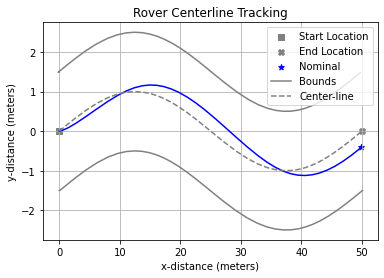

In [4]:
p = RoverParam(linetype="sine")
mdl = Rover(p=p)
results, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

The performance of the rover in these situations is dependent on the parameters of the situation (e.g., the radius of the curve and the amplitude of the sine wave). Thus, it is important to define the operational envelope for the system. This can be done using a `NominalApproach`, which can be used to define ranges of variables to simulate the system under.

In [5]:
from fmdtools.sim.approach import NominalApproach

In [6]:
help(NominalApproach)

Help on class NominalApproach in module fmdtools.sim.approach:

class NominalApproach(builtins.object)
 |  Class for defining sets of nominal simulations. To explain, a given system 
 |  may have a number of input situations (missions, terrain, etc) which the 
 |  user may want to simulate to ensure the system operates as desired. This 
 |  class (in conjunction with propagate.nominal_approach()) can be used to 
 |  perform these simulations.
 |  
 |  Attributes
 |  ----------
 |  scenarios : dict
 |      scenarios to inject based on the approach
 |  num_scenarios : int
 |      number of scenarios in the approach
 |  ranges : dict
 |      dict of the parameters defined in each method for the approach
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Instantiates NominalApproach (simulation p are defined using methods)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  add_param_ranges(self, paramfunc, rangeid, *args, replicates=1, seeds='shared', set_args={}, **kw

In this approach we define parameter ranges for the two major situations--a wavelength and amplitude for the sine wave, and a radius and start location for the turn.

Defining an approach in terms of ranges is performed with `.add_param_ranges()`

In [7]:
nomapp = NominalApproach()
help(nomapp.add_param_ranges)

Help on method add_param_ranges in module fmdtools.sim.approach:

add_param_ranges(paramfunc, rangeid, *args, replicates=1, seeds='shared', set_args={}, **kwargs) method of fmdtools.sim.approach.NominalApproach instance
    Adds a set of scenarios to the approach.
    
    Parameters
    ----------
    paramfunc : method
        Python method which generates a set of model parameters given the input arguments.
        method should have form: method(fixedarg, fixedarg..., inputarg=X, inputarg=X)
    rangeid : str
        Name for the range being used. Default is 'nominal'
    *args: specifies values for positional args of paramfunc.
        May be given as a fixed float/int/dict/str defining a set value for positional arguments
    replicates : int
        Number of points to take over each range (for random parameters). Default is 1.
    seeds : str/list
        Options for seeding models/replicates: (Default is 'shared')
            - 'shared' creates random seeds and shares them bet

In [8]:
nomapp.add_param_ranges(RoverParam,'sine', linetype='sine', amp=(0, 10, 0.2), wavelength=(10.0,50.0,10.0))
nomapp.add_param_ranges(RoverParam,'turn', linetype='turn', radius=(5.0,40.0,5.0), start=(0.0, 20.0,5.0))

Notice that `RoverParam` is the class that generatse the nominal parameters of the model, `linetype = 'sine'` is a fixed parameter defining a discrete case of scenarios, and `amp` and `wavelenth` are parameters that are varied (the given tuples define the respective ranges).

The result is a defined set of scenarios which can be run in the model:

In [9]:
nomapp.scenarios

{'sine_1': ParamScenario(sequence={}, times=(), p=RoverParam(linetype='sine', period=0.6283185307179586, end=(10.0, 0.0), initangle=0.0, amp=0.0, wavelength=10.0, radius=20.0, start=20.0, ub_f=10.0, lb_f=-1.0, ub_t=10.0, lb_t=-1.0, ub_d=2.0, lb_d=-2.0, cor_d=1.0, cor_t=1.0, cor_f=1.0, degradation=DegParam(friction=0.0, drift=0.0), drive_modes={'mode_args': 'set'}), r={'seed': 662546124}, sp={}, prob=0.005, inputparams={'amp': 0.0, 'wavelength': 10.0, 'linetype': 'sine'}, rangeid='sine', name='sine_1', paramfunc=<class 'rover_model.RoverParam'>, fixedargs=(), fixedkwargs={'linetype': 'sine'}),
 'sine_2': ParamScenario(sequence={}, times=(), p=RoverParam(linetype='sine', period=0.3141592653589793, end=(20.0, 0.0), initangle=0.0, amp=0.0, wavelength=20.0, radius=20.0, start=20.0, ub_f=10.0, lb_f=-1.0, ub_t=10.0, lb_t=-1.0, ub_d=2.0, lb_d=-2.0, cor_d=1.0, cor_t=1.0, cor_f=1.0, degradation=DegParam(friction=0.0, drift=0.0), drive_modes={'mode_args': 'set'}), r={'seed': 662546124}, sp={}, pr

Nominal Approaches are simulated using `prop.nominal_approach`.

In [10]:
help(prop.nominal_approach)

Help on function nominal_approach in module fmdtools.sim.propagate:

nominal_approach(mdl, nomapp, **kwargs)
    Simulates a set of nominal scenarios through a model. Useful to understand
    the sets of parameters where the system will run nominally and/or lead to
    a fault.
    
    Parameters
    ----------
    mdl : Simulable
        Model to simulate
    nomapp : NominalApproach
        Nominal Approach defining the nominal scenarios to run the system over.
    get_endclass : bool
        Whether to return endclasses from mdl.find_classification. Default is True.
    **kwargs : kwargs
        Additional keyword arguments, may include:
    
        - :data:`sim_kwargs` : kwargs
              Simulation options for :func:`prop_one_scen`
        - :data:`run_kwargs` : kwargs
              Run options for :func:`nom_helper` and others
        - :data:`mult_kwargs` : kwargs
              Multi-scenario options
    
    Returns
    -------
    nomresults: Result
        Result dict of

In [11]:
endclasses, mdlhists= prop.nominal_approach(mdl, nomapp)

SCENARIOS COMPLETE:   0%|          | 0/228 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   1%|          | 2/228 [00:00<00:13, 17.35it/s]

SCENARIOS COMPLETE:   2%|▏         | 4/228 [00:00<00:12, 17.36it/s]

SCENARIOS COMPLETE:   3%|▎         | 6/228 [00:00<00:13, 16.93it/s]

SCENARIOS COMPLETE:   4%|▎         | 8/228 [00:00<00:12, 17.10it/s]

SCENARIOS COMPLETE:   4%|▍         | 10/228 [00:00<00:13, 15.68it/s]

SCENARIOS COMPLETE:   5%|▌         | 12/228 [00:00<00:14, 14.45it/s]

SCENARIOS COMPLETE:   6%|▌         | 14/228 [00:00<00:16, 12.87it/s]

SCENARIOS COMPLETE:   7%|▋         | 16/228 [00:01<00:17, 12.15it/s]

SCENARIOS COMPLETE:   8%|▊         | 18/228 [00:01<00:18, 11.41it/s]

SCENARIOS COMPLETE:   9%|▉         | 20/228 [00:01<00:16, 12.76it/s]

SCENARIOS COMPLETE:  10%|▉         | 22/228 [00:01<00:15, 13.41it/s]

SCENARIOS COMPLETE:  11%|█         | 24/228 [00:01<00:13, 14.76it/s]

SCENARIOS COMPLETE:  11%|█▏        | 26/228 [00:01<00:13, 14.92it/s]

SCENARIOS COMPLETE:  12%|█▏        | 28/228 [00:01<00:13, 15.03it/s]

SCENARIOS COMPLETE:  13%|█▎        | 30/228 [00:02<00:13, 15.11it/s]

SCENARIOS COMPLETE:  14%|█▍        | 32/228 [00:02<00:12, 15.49it/s]

SCENARIOS COMPLETE:  15%|█▍        | 34/228 [00:02<00:13, 14.90it/s]

SCENARIOS COMPLETE:  16%|█▌        | 36/228 [00:02<00:12, 14.80it/s]

SCENARIOS COMPLETE:  17%|█▋        | 38/228 [00:02<00:12, 14.95it/s]

SCENARIOS COMPLETE:  18%|█▊        | 40/228 [00:02<00:13, 13.88it/s]

SCENARIOS COMPLETE:  18%|█▊        | 42/228 [00:02<00:12, 14.77it/s]

SCENARIOS COMPLETE:  19%|█▉        | 44/228 [00:03<00:12, 14.92it/s]

SCENARIOS COMPLETE:  20%|██        | 46/228 [00:03<00:12, 14.32it/s]

SCENARIOS COMPLETE:  21%|██        | 48/228 [00:03<00:12, 14.61it/s]

SCENARIOS COMPLETE:  22%|██▏       | 50/228 [00:03<00:12, 14.81it/s]

SCENARIOS COMPLETE:  23%|██▎       | 52/228 [00:03<00:11, 14.74it/s]

SCENARIOS COMPLETE:  24%|██▎       | 54/228 [00:03<00:11, 14.90it/s]

SCENARIOS COMPLETE:  25%|██▍       | 56/228 [00:03<00:11, 15.02it/s]

SCENARIOS COMPLETE:  25%|██▌       | 58/228 [00:03<00:10, 15.65it/s]

SCENARIOS COMPLETE:  26%|██▋       | 60/228 [00:04<00:10, 15.32it/s]

SCENARIOS COMPLETE:  27%|██▋       | 62/228 [00:04<00:10, 15.31it/s]

SCENARIOS COMPLETE:  28%|██▊       | 64/228 [00:04<00:11, 14.58it/s]

SCENARIOS COMPLETE:  29%|██▉       | 66/228 [00:04<00:10, 14.79it/s]

SCENARIOS COMPLETE:  30%|██▉       | 68/228 [00:04<00:10, 15.48it/s]

SCENARIOS COMPLETE:  31%|███       | 70/228 [00:04<00:10, 15.42it/s]

SCENARIOS COMPLETE:  32%|███▏      | 72/228 [00:04<00:09, 15.95it/s]

SCENARIOS COMPLETE:  32%|███▏      | 74/228 [00:05<00:09, 16.09it/s]

SCENARIOS COMPLETE:  33%|███▎      | 76/228 [00:05<00:09, 16.45it/s]

SCENARIOS COMPLETE:  34%|███▍      | 78/228 [00:05<00:09, 15.92it/s]

SCENARIOS COMPLETE:  35%|███▌      | 80/228 [00:05<00:09, 15.90it/s]

SCENARIOS COMPLETE:  36%|███▌      | 82/228 [00:05<00:09, 15.81it/s]

SCENARIOS COMPLETE:  37%|███▋      | 84/228 [00:05<00:08, 16.33it/s]

SCENARIOS COMPLETE:  38%|███▊      | 86/228 [00:05<00:08, 16.36it/s]

SCENARIOS COMPLETE:  39%|███▊      | 88/228 [00:05<00:08, 16.39it/s]

SCENARIOS COMPLETE:  39%|███▉      | 90/228 [00:05<00:08, 16.90it/s]

SCENARIOS COMPLETE:  40%|████      | 92/228 [00:06<00:07, 17.09it/s]

SCENARIOS COMPLETE:  41%|████      | 94/228 [00:06<00:07, 16.88it/s]

SCENARIOS COMPLETE:  42%|████▏     | 96/228 [00:06<00:07, 17.28it/s]

SCENARIOS COMPLETE:  43%|████▎     | 98/228 [00:06<00:07, 17.38it/s]

SCENARIOS COMPLETE:  44%|████▍     | 100/228 [00:06<00:07, 17.88it/s]

SCENARIOS COMPLETE:  45%|████▍     | 102/228 [00:06<00:07, 17.72it/s]

SCENARIOS COMPLETE:  46%|████▌     | 104/228 [00:06<00:07, 17.61it/s]

SCENARIOS COMPLETE:  46%|████▋     | 106/228 [00:06<00:06, 17.53it/s]

SCENARIOS COMPLETE:  47%|████▋     | 108/228 [00:06<00:06, 17.48it/s]

SCENARIOS COMPLETE:  48%|████▊     | 110/228 [00:07<00:06, 17.15it/s]

SCENARIOS COMPLETE:  49%|████▉     | 112/228 [00:07<00:06, 17.06it/s]

SCENARIOS COMPLETE:  50%|█████     | 114/228 [00:07<00:06, 17.30it/s]

SCENARIOS COMPLETE:  51%|█████▏    | 117/228 [00:07<00:06, 17.50it/s]

SCENARIOS COMPLETE:  52%|█████▏    | 119/228 [00:07<00:06, 17.46it/s]

SCENARIOS COMPLETE:  54%|█████▎    | 122/228 [00:07<00:05, 17.84it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 124/228 [00:07<00:05, 17.71it/s]

SCENARIOS COMPLETE:  55%|█████▌    | 126/228 [00:08<00:05, 17.35it/s]

SCENARIOS COMPLETE:  56%|█████▌    | 128/228 [00:08<00:05, 17.35it/s]

SCENARIOS COMPLETE:  57%|█████▋    | 130/228 [00:08<00:05, 17.35it/s]

SCENARIOS COMPLETE:  58%|█████▊    | 132/228 [00:08<00:05, 17.37it/s]

SCENARIOS COMPLETE:  59%|█████▉    | 134/228 [00:08<00:05, 17.37it/s]

SCENARIOS COMPLETE:  60%|█████▉    | 136/228 [00:08<00:05, 17.08it/s]

SCENARIOS COMPLETE:  61%|██████    | 138/228 [00:08<00:05, 16.51it/s]

SCENARIOS COMPLETE:  61%|██████▏   | 140/228 [00:08<00:05, 16.76it/s]

SCENARIOS COMPLETE:  62%|██████▏   | 142/228 [00:08<00:05, 16.93it/s]

SCENARIOS COMPLETE:  63%|██████▎   | 144/228 [00:09<00:04, 17.06it/s]

SCENARIOS COMPLETE:  64%|██████▍   | 146/228 [00:09<00:04, 17.14it/s]

SCENARIOS COMPLETE:  65%|██████▍   | 148/228 [00:09<00:04, 16.93it/s]

SCENARIOS COMPLETE:  66%|██████▌   | 150/228 [00:09<00:04, 17.06it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 152/228 [00:09<00:04, 17.15it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 154/228 [00:09<00:04, 17.21it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 156/228 [00:09<00:04, 17.25it/s]

SCENARIOS COMPLETE:  69%|██████▉   | 158/228 [00:09<00:04, 17.02it/s]

SCENARIOS COMPLETE:  70%|███████   | 160/228 [00:10<00:03, 17.12it/s]

SCENARIOS COMPLETE:  71%|███████   | 162/228 [00:10<00:03, 17.19it/s]

SCENARIOS COMPLETE:  72%|███████▏  | 164/228 [00:10<00:03, 17.24it/s]

SCENARIOS COMPLETE:  73%|███████▎  | 166/228 [00:10<00:03, 17.02it/s]

SCENARIOS COMPLETE:  74%|███████▎  | 168/228 [00:10<00:03, 17.39it/s]

SCENARIOS COMPLETE:  75%|███████▍  | 170/228 [00:10<00:03, 17.09it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 172/228 [00:10<00:03, 17.17it/s]

SCENARIOS COMPLETE:  76%|███████▋  | 174/228 [00:10<00:03, 17.22it/s]

SCENARIOS COMPLETE:  77%|███████▋  | 176/228 [00:10<00:03, 17.26it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 178/228 [00:11<00:02, 17.29it/s]

SCENARIOS COMPLETE:  79%|███████▉  | 180/228 [00:11<00:02, 16.99it/s]

SCENARIOS COMPLETE:  80%|███████▉  | 182/228 [00:11<00:02, 17.15it/s]

SCENARIOS COMPLETE:  81%|████████  | 184/228 [00:11<00:02, 17.21it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 186/228 [00:11<00:02, 17.25it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 188/228 [00:11<00:02, 17.28it/s]

SCENARIOS COMPLETE:  83%|████████▎ | 190/228 [00:11<00:02, 17.30it/s]

SCENARIOS COMPLETE:  84%|████████▍ | 192/228 [00:11<00:02, 17.32it/s]

SCENARIOS COMPLETE:  85%|████████▌ | 194/228 [00:12<00:01, 17.04it/s]

SCENARIOS COMPLETE:  86%|████████▌ | 196/228 [00:12<00:01, 17.13it/s]

SCENARIOS COMPLETE:  87%|████████▋ | 198/228 [00:12<00:01, 17.20it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 200/228 [00:12<00:01, 17.25it/s]

SCENARIOS COMPLETE:  89%|████████▊ | 202/228 [00:12<00:01, 17.28it/s]

SCENARIOS COMPLETE:  89%|████████▉ | 204/228 [00:12<00:01, 17.65it/s]

SCENARIOS COMPLETE:  90%|█████████ | 206/228 [00:12<00:01, 17.22it/s]

SCENARIOS COMPLETE:  91%|█████████ | 208/228 [00:12<00:01, 17.67it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 210/228 [00:12<00:01, 17.57it/s]

SCENARIOS COMPLETE:  93%|█████████▎| 212/228 [00:13<00:00, 17.51it/s]

SCENARIOS COMPLETE:  94%|█████████▍| 215/228 [00:13<00:00, 17.90it/s]

SCENARIOS COMPLETE:  95%|█████████▌| 217/228 [00:13<00:00, 18.16it/s]

SCENARIOS COMPLETE:  96%|█████████▌| 219/228 [00:13<00:00, 17.92it/s]

SCENARIOS COMPLETE:  97%|█████████▋| 221/228 [00:13<00:00, 17.76it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 223/228 [00:13<00:00, 17.64it/s]

SCENARIOS COMPLETE:  99%|█████████▊| 225/228 [00:13<00:00, 17.56it/s]

SCENARIOS COMPLETE: 100%|█████████▉| 227/228 [00:13<00:00, 17.50it/s]

SCENARIOS COMPLETE: 100%|██████████| 228/228 [00:13<00:00, 16.37it/s]

To speed up execution over large numbers of scenarios, multiprocessing can also be used to run the scenarios in parallel by passing an execution pool. This is not done here because it would require the model to be in a different file, and because the gains on a light-weight model like this are not significant.

Now that the approach has been simulated, the operational envelope can be visualized. There are three methods to perform this visualization `an.plot.nominal_vals_1d`, `an.plot.nominal_vals_2d`, and `an.plot.nominal_vals_3d`, which each plot the *classification* of the model in the 1/2/3 dimensions over the set of given parameters as nominal or incomplete. 

Note that this classification must be in the dictionary returned from the Model's `find_classification` function at the end of the model run under the key `classification` as is done in the rover model. This classification must also be encoded as a string.

In [12]:
help(an.plot.nominal_vals_2d)

Help on function nominal_vals_2d in module fmdtools.analyze.plot:

nominal_vals_2d(nomapp, endclasses, x_param, y_param, only_params=False, default_param=0, title='Nominal Operational Envelope', nom_func=<function <lambda> at 0x000001263EE81B80>, metric='cost', figsize=(6, 4), xlabel='', ylabel='', nom_alpha=0.5, nom_color='blue', nom_marker='o', fault_alpha=0.5, fault_color='red', fault_marker='X', legend_loc='best')
    Visualizes the nominal operational envelope along two given parameters
    
    Parameters
    ----------
    nomapp : NominalApproach
        Nominal sample approach simulated in the model.
    endclasses : Result
        Result dict for the set of simulations produced by running the model over nomapp
    x_param : str
        Parameter range desired to visualize on the x-axis. Can be any
        property that changes over the nomapp
        (e.g., `r.seed`, `inputparam.x_in`, `p.x`...)
    y_param : str
        Parameter range desired to visualize on the y-axis. Can

We can then use these results to visualize the operational envelope for the system over each case. In this case, the parameter ranges of the sine wave are plotted, showing that the rover can only a low ration of amplitude to wavelenght.

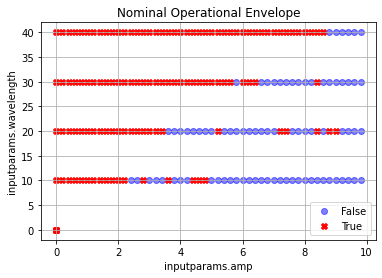

In [13]:
fig = an.plot.nominal_vals_2d(nomapp, endclasses, 'inputparams.amp', 'inputparams.wavelength', metric = 'at_finish')

The plot below shows the same results for the turn parameters.

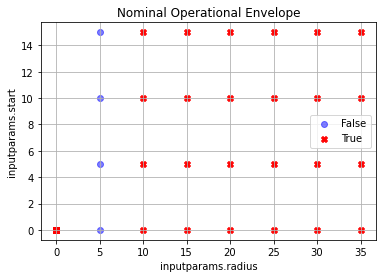

In [14]:
fig = an.plot.nominal_vals_2d(nomapp, endclasses, 'inputparams.radius', 'inputparams.start', metric = 'at_finish')

Because the primary effect is one in terms of radius, we might visualize this trend in one dimension instead:

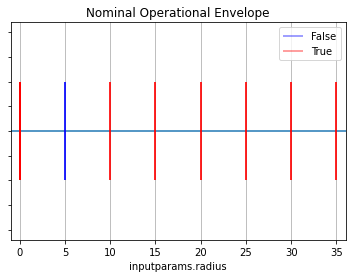

In [15]:
fig = an.plot.nominal_vals_1d(nomapp, endclasses, 'inputparams.radius', metric = 'at_finish')

While this is helpful for plotting string classifications, we also might want to compare numeric quantities (e.g., costs, hazard probabilities, etc) over the set of factors. For this, `an.tabulate.nominal_factor_comparison` is used, which creates a table of  metrics over a given set of parameters.

In [16]:
help(an.tabulate.nominal_factor_comparison)

Help on function nominal_factor_comparison in module fmdtools.analyze.tabulate:

nominal_factor_comparison(nomapp, endclasses, params, metrics='all', rangeid='default', nan_as=nan, percent=True, give_ci=False, **kwargs)
    Compares a metric for a given set of model parameters/factors over set of nominal scenarios.
    
    Parameters
    ----------
    nomapp : NominalApproach
        Nominal Approach used to generate the simulations
    endclasses : dict
        dict of endclasses from propagate.nominal_approach or nested_approach with structure: 
            {scen_x:{metric1:x, metric2:x...}} or {scen_x:{fault:{metric1:x, metric2:x...}}} 
    params : list/str
        List of parameters (or parameter) to use for the factor levels in the comparison
    metrics : 'all'/list, optional
        Metrics to show in the table. The default is 'all'.
    rangeid : str, optional
        Nominal Approach range to use for the test, if run over a single range.
        The default is 'default', wh

In [17]:
endclasses.state_probabilities()

{'nominal mission': 1.4471428571428586,
 'incomplete mission': 0.552857142857143}

In [18]:
nomtab = an.tabulate.nominal_factor_comparison(nomapp, endclasses, ['inputparams.radius', 'inputparams.start'], rangeid='turn', percent=False)

AttributeError: 'float' object has no attribute 'get'

In [ ]:
nomtab

This table can also be summarized on individual factors:

In [ ]:
nomtab_summ = an.tabulate.nominal_factor_comparison(nomapp, endclasses, ['start'], rangeid='turn', percent=False)
nomtab_summ

`an.plot.nominal_factor_comparison` can then be used to visualize one metric from this table as a bar plot.

In [ ]:
help(an.plot.nominal_factor_comparison)

In [ ]:
fig = an.plot.nominal_factor_comparison(nomtab_summ, 'cost', ylabel='cost', title='average cost at different start locations', maxy=150)

## Quantifying probabilities

Given the ability to simulate over ranges, it can additionally be used to quantify probabilities of the different end-state classifications. `an.process.state_probabilities(endclasses)` can be used to quantify the probability these classifications.

The default probability model over ranges is to assume a uniform distribution and only assume one range has been added. This can lead to fallacious results:

In [19]:
state_probabilities = endclasses.state_probabilities()
state_probabilities

Thus, `.assoc_probs` to:
- associate the probabilities with their corresponding distributions (which may be non-uniform), and
- rebalance the overall probability of discrete cases
when running the approach over ranges. 

In [20]:
help(nomapp.assoc_probs)

Here, each case is given a weight defining the probability of the discrete case, while the corresponding parameters are given corresponding pdf functions (in this case uniform distributions from the scipy stats package).

In [21]:
from scipy import stats

In [22]:
nomapp.assoc_probs('sine', prob_weight=0.5, amp=(stats.uniform.pdf, {'loc':0,'scale':10}), wavelength=(stats.uniform.pdf,{'loc':10, 'scale':40}))
nomapp.assoc_probs('turn', prob_weight=0.5, start=(stats.uniform.pdf, {'loc':5,'scale':10}), radius=(stats.uniform.pdf,{'loc':5, 'scale':30}))

Now, when the scenarios are run, they should have the correct corresponding probabilities:

In [23]:
endclasses, mdlhists= prop.nominal_approach(mdl, nomapp)

In [24]:
state_probabilities = endclasses.state_probabilities()
state_probabilities

This result (while seemingly extreme due to the large ranges explored) is consistent with the operational envelopes presented earlier.

## Random input generation

It may additionally be helpful to perform simulations over randomly generated inputs, when there are many parameters and it is difficult to easily quantify the stochastic process. This approach is called Monte Carlo sampling, and enables one to quantify probabilities given stochasticly-generated inputs. Random inputs are assigned using `.add_rand_params`

In [25]:
nomapp_rand = NominalApproach()
help(nomapp_rand.add_rand_params)

Below, the same probability model/scenarios used above will be generated using stochastic inputs (rather than a range).

In [ ]:
import numpy as np

In [ ]:
nomapp_rand.add_rand_params(RoverParam,'sine', 'sine', prob_weight=0.5, replicates=100, amp=(np.random.uniform, 0, 10), wavelength=(np.random.uniform,10,40))
nomapp_rand.add_rand_params(RoverParam,'turn', 'turn', prob_weight=0.5, replicates=100, radius=(np.random.uniform,5,40), start=(np.random.uniform,0, 20))

We can go through the same process to verify that it tracks the range/pdf method.

In [ ]:
endclasses, mdlhists= prop.nominal_approach(mdl, nomapp_rand)

In [ ]:
fig = an.plot.nominal_vals_2d(nomapp_rand, endclasses,'inputparams.amp', 'inputparams.wavelength', metric = 'at_finish')

In [ ]:
fig = an.plot.nominal_vals_2d(nomapp_rand, endclasses, 'inputparams.radius', 'inputparams.start', metric = 'at_finish')

In [ ]:
fig = an.plot.nominal_vals_1d(nomapp_rand, endclasses, 'inputparams.radius', metric = 'at_finish')

As shown, these results track the uniform approach, although the spread catches some non-nominal scenarios that were not caught using uniform sampling. The resulting probabilities are:

In [ ]:
state_probabilities = an.process.state_probabilities(endclasses)
state_probabilities

Which is similar to (but not exactly the same as) the uniform approach. The error of Monte Carlo sampling approaches can be reduced by increasing the number of points, but these points increase computational costs.

## Nested Scenario Sampling

Thus far, we have introduced two types of approaches: 
- SampleApproach, which is used to evaluate the system resilience to a set of faults
- NominalApproach, which is used to evaluate system performance over a set of parameters

These both have their limitations when used alone. Simulating a `SampleApproach` using `propagate.approach` solely evaluates evaluates fault-driven hazards in a single nominal set of parameters (which may not generalize) while simulating a `NominalApproach` using `propagate.nominal_approach` evaluates the systerm performance/resilience to external parameters (But not faults).

To resolve these limitations, one can use a *nested* scenario sampling approach where a `SampleApproach` is simulated at each parameter level of a `NominalApproach`, giving the resilience of the system to faults over a set of operational parameters. This is called using the `propagate.nested_approach` method.

In [ ]:
help(prop.nested_approach)

Here we use the nominal approach generated earlier with a default sampling approach to quantify resilience.

In [ ]:
nested_endclasses, nested_mdlhists, nested_apps = prop.nested_approach(mdl, nomapp)

 The resulting endclass/mdlhist dictionary is in turn nested within operational scenarios.

In [ ]:
nested_endclasses.keys()

In [ ]:
nested_endclasses.sine_1.nominal

We can compare resilience to faults over the operational envelope using `an.tabulate.resilience_factor_comparison`, which generates at table similar to `an.tabulate.nominal_factor_comparison` except for a single metric with rows for each fault scenario.

In [ ]:
restab = an.tabulate.nested_factor_comparison(nomapp, nested_endclasses,['start'], 'cost', rangeid='turn', percent=False, difference=False)

In [ ]:
restab

These factors can further be visualized using `an.plot.nested_factor_comparison`, which generates a set of bar graphs similar to `an.plot.nominal_factor_comparison`.

In [ ]:
help(an.plot.nested_factor_comparison)

In [ ]:
fig = an.plot.nested_factor_comparison(restab, stat='cost', figsize = (6,4), xlabel='curve start point')

As shown, on average the costs are higher over fault scenarios than in their nominal counterparts. While this difference appears to be uniform for Avionics faults (`no_con`, which merely adds a fault at the times instantiated (since the rover is already in `drive` mode)), resulting in a uniform cost of 100), it changes for the Drive fault depending on the location of the curve. This is because in some cases this fault stops the rover at the finish line (when the line is short), and sometimes during its mission (when the line is long), leading to a cost from the incomplete mission.

Thus, the assessed consequences of faults are somewhat prone to parameters leading to a different injection time. We might prefer, for example, for avionics faults to be injected when they would make a difference (i.e. at the start) and for drive faults to be injected multiple. This can be fixed by:
- encoding phase information in with modes to ensure they are injected at the right intervals
- using the `get_phases` option in `propagate.nested_approach` to get the phases and inject the faults in the corresponding times
- passing appropriate Approach arguments to `propagate.nested_approach` (e.g., defaultsamp, etc)

This has already been done in the Power faults, which we evaluate below. (note that they were not included above because they were listed to be injected in specific phases using the `key_phases_by` option in `assoc_modes()`).

In [ ]:
nested_endclasses_power, nested_mdlhists_power, nested_apps_power = prop.nested_approach(mdl, nomapp, get_phases=True, faults='Power')

In [ ]:
restab_power = an.tabulate.nested_factor_comparison(nomapp, nested_endclasses_power,['start'], 'cost', rangeid='turn', difference=True, percent=False, faults='modes')
restab_power

In [ ]:
fig = an.plot.nested_factor_comparison(restab_power, stat='cost', figsize = (6,4), xlabel='curve start point', stack=True, maxy=800)

As shown, all power faults result in the same cost, since they all result in both a fault and an incomplete mission, in part because none of them are injected after the rover completes its mission (which would happen if we were using the global phases as in the drive faults).